<a href="https://colab.research.google.com/github/vektor8891/llm/blob/main/projects/05_text_generator/05_text_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# !pip install torchtext==0.15.1

## Defining helper functions

In [1]:
def preprocess_string(s):
    import re

    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

## Language modeling

In [2]:
song= """We are no strangers to love
You know the rules and so do I
A full commitments what Im thinking of
You wouldnt get this from any other guy
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
And if you ask me how Im feeling
Dont tell me youre too blind to see
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you"""

In [102]:
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

def preprocess(words):
    import string
    tokens=word_tokenize(words)
    tokens=[preprocess_string(w)   for w in tokens]
    return [w.lower()  for w in tokens if len(w)!=0 or not(w in string.punctuation) ]

tokens=preprocess(song)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [7]:
tokens[0:10]

['we', 'are', 'no', 'strangers', 'to', 'love', 'you', 'know', 'the', 'rules']

In [8]:
# Create a frequency distribution of words
fdist = nltk.FreqDist(tokens)
fdist

FreqDist({'na': 40, 'gon': 38, 'you': 37, 'never': 36, 'and': 16, 'tell': 9, 'make': 8, 'say': 8, 'a': 7, 'give': 6, ...})

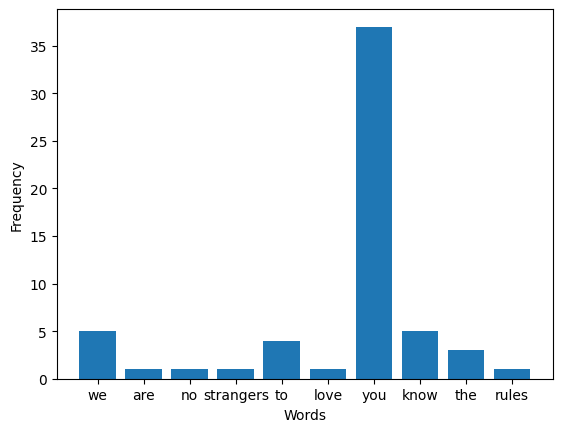

In [9]:
import matplotlib.pyplot as plt

plt.bar(list(fdist.keys())[0:10],list(fdist.values())[0:10])
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

## Unigram model

In [10]:
#total count of each word
C=sum(fdist.values())
C

385

In [11]:
fdist['strangers']/C

0.0025974025974025974

In [12]:
vocabulary=set(tokens)

##  Bigram model

In [14]:
bigrams = nltk.bigrams(tokens)
bigrams

<generator object bigrams at 0x7d75ae6083c0>

In [15]:
my_bigrams=list(nltk.bigrams(tokens))

In [16]:
my_bigrams[0:10]

[('we', 'are'),
 ('are', 'no'),
 ('no', 'strangers'),
 ('strangers', 'to'),
 ('to', 'love'),
 ('love', 'you'),
 ('you', 'know'),
 ('know', 'the'),
 ('the', 'rules'),
 ('rules', 'and')]

In [17]:
freq_bigrams  = nltk.FreqDist(nltk.bigrams(tokens))
freq_bigrams

FreqDist({('gon', 'na'): 38, ('never', 'gon'): 36, ('you', 'never'): 9, ('na', 'tell'): 8, ('make', 'you'): 8, ('na', 'give'): 6, ('give', 'you'): 6, ('you', 'up'): 6, ('up', 'never'): 6, ('na', 'let'): 6, ...})

In [18]:
freq_bigrams[('we', 'are')]

1

In [19]:
for my_bigram in  my_bigrams[0:10]:
    print(my_bigram)
    print(freq_bigrams[my_bigram])

('we', 'are')
1
('are', 'no')
1
('no', 'strangers')
1
('strangers', 'to')
1
('to', 'love')
1
('love', 'you')
1
('you', 'know')
1
('know', 'the')
3
('the', 'rules')
1
('rules', 'and')
1


In [20]:
word="strangers"
vocab_probabilities={}
for next_word in vocabulary:
    vocab_probabilities[next_word]=freq_bigrams[(word,next_word)]/fdist[word]

vocab_probabilities=sorted(vocab_probabilities.items(), key=lambda x:x[1],reverse=True)
vocab_probabilities[0:4]

[('to', 1.0), ('wouldnt', 0.0), ('a', 0.0), ('got', 0.0)]

In [21]:
def make_predictions(my_words, freq_grams, normlize=1, vocabulary=vocabulary):
    """
    Generate predictions for the conditional probability of the next word given a sequence.

    Args:
        my_words (list): A list of words in the input sequence.
        freq_grams (dict): A dictionary containing frequency of n-grams.
        normlize (int): A normalization factor for calculating probabilities.
        vocabulary (list): A list of words in the vocabulary.

    Returns:
        list: A list of predicted words along with their probabilities, sorted in descending order.
    """

    vocab_probabilities = {}  # Initialize a dictionary to store predicted word probabilities

    context_size = len(list(freq_grams.keys())[0])  # Determine the context size from n-grams keys

    # Preprocess input words and take only the relevant context words
    my_tokens = preprocess(my_words)[0:context_size - 1]

    # Calculate probabilities for each word in the vocabulary given the context
    for next_word in vocabulary:
        temp = my_tokens.copy()
        temp.append(next_word)  # Add the next word to the context

        # Calculate the conditional probability using the frequency information
        if normlize!=0:
            vocab_probabilities[next_word] = freq_grams[tuple(temp)] / normlize
        else:
            vocab_probabilities[next_word] = freq_grams[tuple(temp)]
    # Sort the predicted words based on their probabilities in descending order
    vocab_probabilities = sorted(vocab_probabilities.items(), key=lambda x: x[1], reverse=True)

    return vocab_probabilities  # Return the sorted list of predicted words and their probabilities

In [23]:
my_words="are"

vocab_probabilities=make_predictions(my_words,freq_bigrams,normlize=fdist['i'])
vocab_probabilities[0:10]

[('no', 0.3333333333333333),
 ('wouldnt', 0.0),
 ('a', 0.0),
 ('got', 0.0),
 ('each', 0.0),
 ('ask', 0.0),
 ('understand', 0.0),
 ('ta', 0.0),
 ('but', 0.0),
 ('cry', 0.0)]

In [24]:
vocab_probabilities[0][0]

'no'

In [26]:
my_song=""
for w in tokens[0:100]:
  my_word=make_predictions(w,freq_bigrams)[0][0]
  my_song+=" "+my_word
my_song

' both no strangers to say you never the game and hurt long i just lie commitments what im feeling of you never get this from any other for i just wan na tell a never im feeling got ta make you never never gon na tell you never never gon na tell you never never gon na tell around and hurt you never gon na tell you never never gon na tell goodbye never gon na tell a lie and hurt you never known each other for so long your hearts been aching but youre too shy to say goodbye'

In [29]:
my_song="i"

for i in range(100):
    my_word=make_predictions(my_word,freq_bigrams)[0][0]
    my_song+=" "+my_word

my_song

'i never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never'

## Trigram model

In [30]:
freq_trigrams = nltk.FreqDist(nltk.trigrams(tokens))
freq_trigrams

FreqDist({('never', 'gon', 'na'): 36, ('you', 'never', 'gon'): 9, ('gon', 'na', 'give'): 6, ('na', 'give', 'you'): 6, ('give', 'you', 'up'): 6, ('you', 'up', 'never'): 6, ('up', 'never', 'gon'): 6, ('gon', 'na', 'let'): 6, ('na', 'let', 'you'): 6, ('let', 'you', 'down'): 6, ...})

In [31]:
make_predictions("so do",freq_trigrams,normlize=freq_bigrams[('do','i')] )[0:10]

[('i', 1.0),
 ('wouldnt', 0.0),
 ('a', 0.0),
 ('got', 0.0),
 ('each', 0.0),
 ('ask', 0.0),
 ('understand', 0.0),
 ('ta', 0.0),
 ('but', 0.0),
 ('cry', 0.0)]

In [32]:
my_song=""

w1=tokens[0]
for w2 in tokens[0:100]:
    gram=w1+' '+w2
    my_word=make_predictions(gram,freq_trigrams )[0][0]
    my_song+=" "+my_word
    w1=w2

my_song

' wouldnt no strangers to love you know the game and so do i a full commitments what im thinking of you wouldnt get this from any other guy i just wan na tell a how im feeling got ta make you cry never gon na give you up never gon na give you down never gon na give around and desert you never gon na give you cry never gon na give goodbye never gon na give a lie and hurt you never known each other for so long your hearts been aching but youre too shy to say it'

Challenges of histogram-based methods:

1. Exponencially increasing number of bins (e.g. in N-word vocabulary, Unigram model has $N$ bins and Bigram model has $N^2$ bins etc).
2. Limitated contextual understanding / not able to capture intricate word relationships (e.g. **don’t like** ~ **dislike**).


# Feedforward Neural Networks (FNNs) for language models

In [36]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")
tokens=tokenizer(song)

## Indexing

In [37]:
from torchtext.vocab import build_vocab_from_iterator

# Create a vocabulary from text tokens

# tokenize the 'song' text using the provided tokenizer.
# The map function applies the tokenizer to each word in the 'song' after splitting it.
# The result is a list of tokens representing the words in the 'song'.
tokenized_song = map(tokenizer, song.split())

# Step 2: Vocabulary Building
# The build_vocab_from_iterator function constructs a vocabulary from the tokenized text.
# In this case, add a special token "<unk>" (unknown token) to handle out-of-vocabulary words.
vocab = build_vocab_from_iterator(tokenized_song, specials=["<unk>"])

# Step 3: Set Default Index
# Set the default index for the vocabulary to the index corresponding to the "<unk>" token.
# This ensures that any unknown tokens in the future will be mapped to this index.
vocab.set_default_index(vocab["<unk>"])

In [39]:
vocab(tokens[0:10])

['we', 'are', 'no', 'strangers', 'to', 'love', 'you', 'know', 'the', 'rules']

In [40]:
text_pipeline = lambda x: vocab(tokenizer(x))
text_pipeline(song)[0:10]

[21, 58, 70, 74, 25, 69, 2, 20, 31, 72]

In [43]:
index_to_token = vocab.get_itos()
index_to_token[0]

'<unk>'

## Embedding layers

In [44]:
import torch.nn as nn

embedding_dim=20
vocab_size=len(vocab)
embeddings = nn.Embedding(vocab_size, embedding_dim)

In [46]:
import torch

for n in range(2):
    embedding=embeddings(torch.tensor(n))
    print("word",index_to_token[n])
    print("index",n)
    print( "embedding", embedding)
    print("embedding shape", embedding.shape)

word <unk>
index 0
embedding tensor([ 0.3628,  0.4222,  1.5373, -0.7966,  1.1816, -0.3817, -0.1848,  0.0559,
        -0.1279,  0.5350, -0.3768,  1.0282,  0.5911,  1.4951,  0.8912,  0.0743,
         1.4045,  0.0606, -0.5057,  0.1065], grad_fn=<EmbeddingBackward0>)
embedding shape torch.Size([20])
word gonna
index 1
embedding tensor([-0.9818, -0.5155, -0.6713, -0.1214,  0.5924,  0.3727,  0.5649,  1.8593,
        -0.3827,  1.1428,  1.5055, -2.0444, -0.0742,  0.7773,  0.8325, -1.6351,
         0.5015,  0.0811, -0.7901,  0.7183], grad_fn=<EmbeddingBackward0>)
embedding shape torch.Size([20])


## Generating context-target pairs (n-grams)

In [47]:
CONTEXT_SIZE=2

ngrams = [
    (
        [tokens[i - j - 1] for j in range(CONTEXT_SIZE)],
        tokens[i]
    )
    for i in range(CONTEXT_SIZE, len(tokens))
]

In [48]:
context, target=ngrams[0]
print("context",context,"target",target)
print("context index",vocab(context),"target index",vocab([target]))

context ['are', 'we'] target no
context index [58, 21] target index [70]


In [50]:
linear = nn.Linear(embedding_dim*CONTEXT_SIZE,128)
linear

Linear(in_features=40, out_features=128, bias=True)

In [57]:
my_embeddings=embeddings(torch.tensor(vocab(context)))
my_embeddings.shape

torch.Size([2, 20])

In [58]:
my_embeddings=my_embeddings.reshape(1,-1)
my_embeddings.shape

torch.Size([1, 40])

## Batch function

In [75]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CONTEXT_SIZE=3
BATCH_SIZE=10
EMBEDDING_DIM = 10

def collate_batch(batch):
    batch_size=len(batch)
    context, target=[],[]
    for i in range(CONTEXT_SIZE,batch_size):
        target.append(vocab([batch[i]]))
        context.append(vocab([batch[i-j-1] for j in range(CONTEXT_SIZE)]))

    return   torch.tensor(context).to(device),  torch.tensor(target).to(device).reshape(-1)

In [76]:
Padding=BATCH_SIZE-len(tokens)%BATCH_SIZE
tokens_pad=tokens+tokens[0:Padding]

In [77]:
dataloader = DataLoader(
     tokens_pad, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch
)

In [107]:
tokens_pad

['we',
 'are',
 'no',
 'strangers',
 'to',
 'love',
 'you',
 'know',
 'the',
 'rules',
 'and',
 'so',
 'do',
 'i',
 'a',
 'full',
 'commitments',
 'what',
 'im',
 'thinking',
 'of',
 'you',
 'wouldnt',
 'get',
 'this',
 'from',
 'any',
 'other',
 'guy',
 'i',
 'just',
 'wanna',
 'tell',
 'you',
 'how',
 'im',
 'feeling',
 'gotta',
 'make',
 'you',
 'understand',
 'never',
 'gonna',
 'give',
 'you',
 'up',
 'never',
 'gonna',
 'let',
 'you',
 'down',
 'never',
 'gonna',
 'run',
 'around',
 'and',
 'desert',
 'you',
 'never',
 'gonna',
 'make',
 'you',
 'cry',
 'never',
 'gonna',
 'say',
 'goodbye',
 'never',
 'gonna',
 'tell',
 'a',
 'lie',
 'and',
 'hurt',
 'you',
 'weve',
 'known',
 'each',
 'other',
 'for',
 'so',
 'long',
 'your',
 'hearts',
 'been',
 'aching',
 'but',
 'youre',
 'too',
 'shy',
 'to',
 'say',
 'it',
 'inside',
 'we',
 'both',
 'know',
 'whats',
 'been',
 'going',
 'on',
 'we',
 'know',
 'the',
 'game',
 'and',
 'were',
 'gonna',
 'play',
 'it',
 'and',
 'if',
 'you'

## Multi-class neural network

In [78]:
import torch.nn.functional as F

class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.context_size=context_size
        self.embedding_dim=embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        embeds=torch.reshape( embeds, (-1,self.context_size * self.embedding_dim))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)

        return out

In [79]:
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)

context, target=next(iter(dataloader))
out=model(context)
out.shape

torch.Size([7, 79])

In [82]:
# Find the index with the highest probability
predicted_index =torch.argmax(out,1)
predicted_index

tensor([67, 72, 18, 72, 23, 61, 61])

In [83]:
# Find the corresponding token
[index_to_token[i.item()] for i in  predicted_index]

['guy', 'rules', 'run', 'rules', 'im', 'commitments', 'commitments']

In [84]:
def write_song(model,number_of_words=100):
    my_song=""
    for i in range(number_of_words):
        with torch.no_grad():
            context=torch.tensor(vocab([tokens[i-j-1] for j in range(CONTEXT_SIZE)])).to(device)
            word_inx=torch.argmax(model(context))
            my_song+=" "+index_to_token[word_inx.detach().item()]

    return my_song

write_song(model)

' rules but im guy rules run rules im commitments commitments ask both but im rules too rules it youre rules rules guy rules commitments rules are rules rules rules long rules rules your guy feeling but but both around tell commitments commitments feeling im rules it rules im rules known rules commitments im both your youre rules commitments im dont rules known youre commitments rules commitments known commitments let rules let commitments it make commitments rules to do rules commitments commitments but rules run strangers rules to but rules but it commitments to commitments commitments but tell known rules both'

## Training

In [86]:
# cross entropy loss between input logits and target
criterion = torch.nn.CrossEntropyLoss()

In [116]:
def train(dataloader, model, number_of_epochs=100, show=10):
    """
    Args:
        dataloader (DataLoader): DataLoader containing training data.
        model (nn.Module): Neural network model to be trained.
        number_of_epochs (int, optional): Number of epochs for training. Default is 100.
        show (int, optional): Interval for displaying progress. Default is 10.

    Returns:
        list: List containing loss values for each epoch.
    """

    MY_LOSS = []  # List to store loss values for each epoch

    # Iterate over the specified number of epochs
    for epoch in tqdm(range(number_of_epochs)):
        total_loss = 0  # Initialize total loss for the current epoch
        my_song = ""    # Initialize a string to store the generated song

        # Iterate over batches in the dataloader
        for context, target in dataloader:
            model.zero_grad()          # Zero the gradients to avoid accumulation
            predicted = model(context)  # Forward pass through the model to get predictions
            loss = criterion(predicted, target.reshape(-1))  # Calculate the loss
            total_loss += loss.item()   # Accumulate the loss

            loss.backward()    # Backpropagation to compute gradients
            optimizer.step()   # Update model parameters using the optimizer

        # Display progress and generate song at specified intervals
        if epoch % show == 0:
            my_song += write_song(model)  # Generate song using the model

            print("Generated Song:")
            print("\n")
            print(my_song)

        MY_LOSS.append(total_loss/len(dataloader))  # Append the total loss for the epoch to MY_LOSS list

    return MY_LOSS  # Return the list of  mean loss values for each epoch

In [90]:
import torch.optim as optim
from tqdm import tqdm


my_loss_list=[]

# Define the context size for the n-gram model
CONTEXT_SIZE = 2

# Create an instance of the NGramLanguageModeler class with specified parameters
model_2 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)

# Define the optimizer for training the model, using stochastic gradient descent (SGD)
optimizer = optim.SGD(model_2.parameters(), lr=0.01)

# Set up a learning rate scheduler using StepLR to adjust the learning rate during training
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.1)

my_loss=train(dataloader,model_2)

  3%|▎         | 3/100 [00:00<00:16,  6.00it/s]

Generated Song:


 you strangers you you you gonna gonna gonna to gonna each shy you blind been cry gonna each gonna cry run each been each how you gonna other gonna each you cry commitments gonna you commitments you each each hurt cry say gonna blind run been you both blind gotta you commitments gonna blind lie were each you gonna gonna blind never cry commitments you blind each blind gonna blind never you gonna each you you run each each both each each shy you going thinking just both and each dont run each you gotta been you thinking been cry


 13%|█▎        | 13/100 [00:01<00:08,  9.80it/s]

Generated Song:


 never never you you you gonna never gonna gonna gonna never you you never you you gonna gonna never you you you never never you you you never gonna never you you you you gonna never you you you you you never gonna never you never gonna gonna never you you never gonna never you and you you never gonna never you you never gonna never you never gonna never you gonna gonna you you never never gonna gonna never gonna gonna never never gonna never gonna gonna gonna you you gonna never never you you you you you never


 24%|██▍       | 24/100 [00:02<00:05, 14.18it/s]

Generated Song:


 never never you you you gonna never never and never and you you never you you and never never you you you never never you you you never gonna hurt you you you you never never you you you you never never gonna tell you never never gonna tell you you never gonna tell you and desert you never gonna tell you never never gonna tell you never gonna tell you gonna and hurt you never never and you you gonna gonna never never you never never gonna and you you gonna never never tell you you you you never


 34%|███▍      | 34/100 [00:02<00:03, 18.85it/s]

Generated Song:


 never never you you to gonna never never and never and you you never you you and never never you you you never never you hurt you never gonna hurt you you you you never never you you make you cry never gonna tell you never never gonna tell you you never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell you lie and hurt you never never and you you gonna gonna never never you never never gonna and desert you gonna never never tell you you the you never


 45%|████▌     | 45/100 [00:03<00:02, 25.89it/s]

Generated Song:


 never never no strangers to gonna never never the game and you you never you you and never never you you you never never you hurt you never gonna hurt you cry you you never im you you make you cry never gonna tell you never never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell you lie and hurt you never never each you you gonna gonna never hearts you aching but gonna too shy to gonna never never tell you you whats been never


 52%|█████▏    | 52/100 [00:03<00:01, 27.57it/s]

Generated Song:


 never never no strangers to gonna never never the game and you you never you lie and never never hurt you you never never you know you never gonna hurt you cry you you how im feeling you make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you never never each other you gonna gonna never hearts you aching but youre too shy to gonna goodbye never we both you whats been going


 63%|██████▎   | 63/100 [00:04<00:02, 16.72it/s]

Generated Song:


 never im no strangers to gonna never never the game and you you never you lie and never never hurt the you never never you know you never gonna hurt you cry you you how im feeling you make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you never never each other for cry gonna never hearts you aching but youre too shy to other goodbye never we both know whats been going


 74%|███████▍  | 74/100 [00:04<00:01, 17.00it/s]

Generated Song:


 never im no strangers to gonna never never the game and you you never you lie and never never know the you never never you know down never gonna i you cry you you how im feeling gotta make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you never never each other for cry gonna never hearts been aching but youre too shy to other goodbye never we both know whats been going


 84%|████████▍ | 84/100 [00:05<00:00, 16.25it/s]

Generated Song:


 never im no strangers to love you never the game and you you never you lie and never im know the you never get you know down never guy i you cry tell you how im feeling gotta make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you never known each other for cry make you hearts been aching but youre too shy to other goodbye inside we both know whats been going


 95%|█████████▌| 95/100 [00:06<00:00, 16.01it/s]

Generated Song:


 never are no strangers to love you never the game and you you never you lie and never im thinking the you never get you know down other guy i you cry tell you how im feeling gotta make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you never known each other for cry make you hearts been aching but youre too shy to other goodbye inside we both know whats been going


100%|██████████| 100/100 [00:06<00:00, 15.11it/s]


In [91]:
# save model
save_path = '2gram.pth'
torch.save(model_2.state_dict(), save_path)
my_loss_list.append(my_loss)

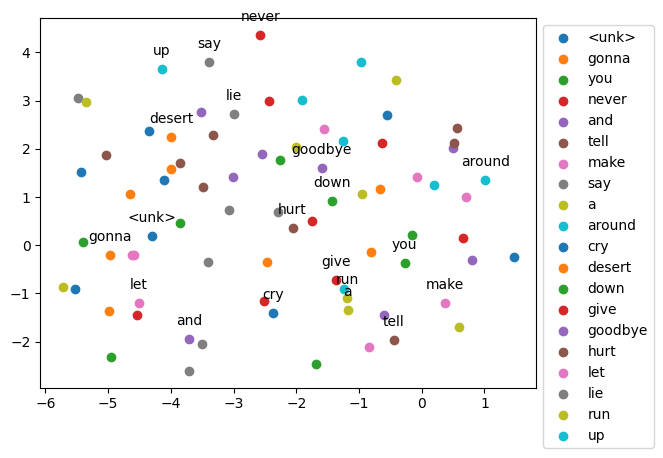

In [92]:
from sklearn.manifold import TSNE

# use TSNE to visualize the structure of the word embeddings
X = model_2.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [93]:
# Repeat process for context of four
CONTEXT_SIZE=4
model_4 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model_4.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
my_loss=train(dataloader,model_4 )

save_path = '4gram.pth'
torch.save(model_4.state_dict(), save_path)

my_loss_list.append(my_loss)

  4%|▍         | 4/100 [00:00<00:06, 15.09it/s]

Generated Song:


 going never never you know i you never around know aching lie you know i <unk> goodbye known to never this know going never to goodbye never never love goodbye i know you do lie know know never lie you you gonna you tell you you goodbye aching for you know never aching you you around tell you game you going you game never around you you what gonna tell you aching know know you going are this guy lie i i around <unk> i tell you aching goodbye you you you you to a you you love know know


 12%|█▏        | 12/100 [00:00<00:07, 11.58it/s]

Generated Song:


 never never never never gonna love you never never gonna gonna gonna you never you never gonna you you never never gonna make you never never never never never never you gonna you you never you never gonna gonna you you gonna gonna tell you never never gonna tell you never never gonna never you gonna never you never gonna make you never never gonna tell you never gonna tell you never gonna you you never never gonna gonna you you you never gonna gonna tell you gonna you you gonna never never gonna gonna you you you gonna and


 26%|██▌       | 26/100 [00:01<00:03, 24.26it/s]

Generated Song:


 never never never never and love you never never and and and you never you never never tell you and tell gonna make you never never never never never never you know tell a never im feeling gonna make you you gonna gonna tell you never never gonna let you down never gonna make around and desert you never gonna make you never never gonna say you never gonna tell a lie and you you never never gonna other you you you never gonna been aching you gonna too you gonna you never never gonna you know love been and


 38%|███▊      | 38/100 [00:01<00:01, 31.23it/s]

Generated Song:


 never never never never to love you never never and and and you never you never never let you how tell gonna make you never never never you never gotta been know tell a how im feeling gotta make you goodbye gonna gonna let you up never gonna let you down never gonna make around and desert you never gonna make you never never gonna say goodbye never gonna tell a lie and hurt you never never each other for you you never gonna been aching but youre too shy to you never never gonna both know whats been going


 46%|████▌     | 46/100 [00:02<00:01, 33.16it/s]

Generated Song:


 never never never never to love you know never and and and you weve a full never both you how tell gonna make you never never never other down gotta been been tell know how im feeling gotta make you goodbye gonna gonna let you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so you feeling gonna been aching but youre too shy to you never never gonna both know whats been going


 54%|█████▍    | 54/100 [00:02<00:01, 33.61it/s]

Generated Song:


 never never never im to love you know never and and were you weve a full never what im thinking tell gonna make you never never never other guy i been been tell know how im feeling gotta make you goodbye gonna gonna let you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so you feeling gonna been aching but youre too shy to see never and gonna both know whats been going


 66%|██████▌   | 66/100 [00:02<00:01, 33.65it/s]

Generated Song:


 never never how strangers to love you know the rules and were you weve a full commitments what im thinking tell gonna make you this never other other guy i been been tell know how im feeling gotta make you goodbye gonna gonna let you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so you feeling to been aching but youre too shy to see never never we both know whats been going


 78%|███████▊  | 78/100 [00:03<00:00, 34.56it/s]

Generated Song:


 never never no strangers to love you know the rules and were you weve a full commitments what im thinking tell gonna make you this never any other guy i been been tell know how im feeling gotta make you goodbye gonna gonna let you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so you feeling to been aching but youre too shy to see never never we both know whats been going


 86%|████████▌ | 86/100 [00:03<00:00, 34.72it/s]

Generated Song:


 never are no strangers to love you know the rules and were you weve a full commitments what im thinking tell gonna make you this from any other guy i been been tell know how im feeling gotta make you goodbye gonna gonna let you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so you feeling to been aching but youre too shy to see never never we both know whats been going


 98%|█████████▊| 98/100 [00:03<00:00, 33.82it/s]

Generated Song:


 never are no strangers to love you know the rules and were you weve a full commitments what im thinking tell gonna make you this from any other guy i been been tell know how im feeling gotta make you goodbye im gonna let you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so you feeling to been aching but youre too shy to see never never we both know whats been going


100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


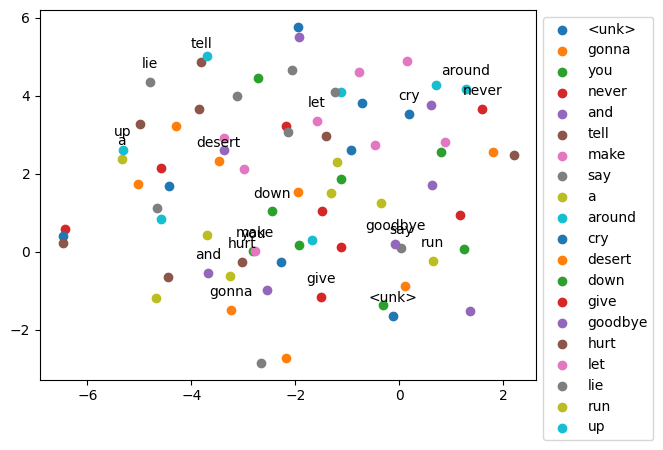

In [94]:
X = model_4.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [95]:
# Repeat process for context of eight
CONTEXT_SIZE=8
model_8 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model_8.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
my_loss=train(dataloader,model_8)

save_path = '8gram.pth'
torch.save(model_8.state_dict(), save_path)

my_loss_list.append(my_loss)

  4%|▍         | 4/100 [00:00<00:02, 33.87it/s]

Generated Song:


 you you hurt you you you you you you you you you you you you wouldnt you you gotta you you the you you you you you you you you so you wouldnt you you you you you you you you you you aching you you gotta you a you you you you rules you you gotta you you gonna you you you you you a you you gotta you you you you you game you you you you you you gotta you you you get each you you game you make get you you you you you you the


 14%|█▍        | 14/100 [00:00<00:03, 22.00it/s]

Generated Song:


 never you make you you you you you you rules gonna tell never gonna you you you you you you you make you gonna you you you you gonna i gonna gonna tell you gonna you you never make you gonna you gonna you you you gonna tell let you down never gonna never around down gonna tell never gonna make you down never gonna never you you gonna tell a you never gonna you never you you you for so gonna gonna tell you gonna tell you gonna shy to make never you you you gonna you been going


 21%|██        | 21/100 [00:01<00:08,  9.56it/s]

Generated Song:


 never you make you up love you you the rules gonna down never gonna you i you i im thinking you make you tell you never you you guy i gonna gonna tell you gonna it you never make you gonna never gonna you you and gonna tell let you down never gonna run around and gonna tell never gonna make you down never gonna say around and gonna tell a lie never hurt you never you make other for so gonna tell tell you gonna down you too shy to make going i give you shy you been going


 35%|███▌      | 35/100 [00:02<00:03, 17.28it/s]

Generated Song:


 never you make you up love you you the rules gonna down never gonna you i you i im thinking you make you tell you never you you guy i gonna gonna tell you gonna too you never make you gonna never gonna say you and gonna tell let you down never gonna run around and gonna tell never gonna make you up never gonna say around and gonna tell a lie never hurt you never you to other for so gonna tell tell you gonna down you too shy to make going on give you shy you been going


 44%|████▍     | 44/100 [00:02<00:02, 20.87it/s]

Generated Song:


 never you make you up love you you the rules gonna down never play you i you i im thinking you make you tell you never hurt you guy i gonna been tell you gonna too you never make you gonna never gonna say you and gonna tell let you down never gonna run around and gonna tell never gonna make you up never gonna say around and gonna tell a lie never hurt you never you to other for so gonna tell tell you gonna down you too shy to make going on give you shy you been going


 53%|█████▎    | 53/100 [00:03<00:02, 20.47it/s]

Generated Song:


 never you make you up love you you the rules gonna down never play you i you i im thinking you make you tell you never hurt you guy i gonna been thinking you gonna too you dont make you gonna never gonna say you and gonna tell let you down never gonna run around and gonna tell never gonna make you up never gonna say around and gonna tell a lie never hurt you never you to other for so gonna tell tell you gonna down you too shy to make going on give you shy you been going


 66%|██████▌   | 66/100 [00:03<00:01, 25.69it/s]

Generated Song:


 never you make you up love you you the rules gonna down never play you i you i im thinking you make you tell you never hurt you guy i gonna too thinking you gonna too you dont make you gonna never gonna say you and gonna tell let you down never gonna run around and gonna tell never gonna make you up never gonna say around and gonna tell a lie never hurt you never you to other for so gonna tell tell you gonna down you too shy to other going on give you shy you been going


 78%|███████▊  | 78/100 [00:04<00:00, 32.29it/s]

Generated Song:


 never you make you up love you you the rules gonna down never play you i you i im thinking you make you tell you never hurt you guy i gonna too thinking you gonna too you dont make you gonna never gonna say you and gonna tell let you down never gonna run around and gonna tell never gonna make you up never gonna say around and gonna tell a lie never hurt you never you to other for so gonna tell tell you gonna down you too shy to other going on give you shy you been going


 86%|████████▌ | 86/100 [00:04<00:00, 32.49it/s]

Generated Song:


 never you make you up love you you the rules gonna down never play you i you hurt im thinking you make you tell you never hurt you guy i been too thinking you gonna too you dont make you gonna never gonna say you and gonna tell let you down never gonna run around and gonna tell never gonna make you up never gonna say around and gonna tell a lie never hurt you never you to other for so gonna tell tell you gonna down you too shy to other going on give you shy you been going


 98%|█████████▊| 98/100 [00:04<00:00, 34.42it/s]

Generated Song:


 never you make you up love you you the rules gonna down never play you i you hurt im thinking you make you tell you never hurt you guy i been too thinking for gonna too you dont make you gonna never gonna say you and gonna tell let you down never gonna run around and gonna tell never gonna make you up never gonna say around and gonna tell a lie never hurt you never you to other for so gonna tell tell you gonna down you too shy to other going on give you shy you been going


100%|██████████| 100/100 [00:04<00:00, 20.88it/s]


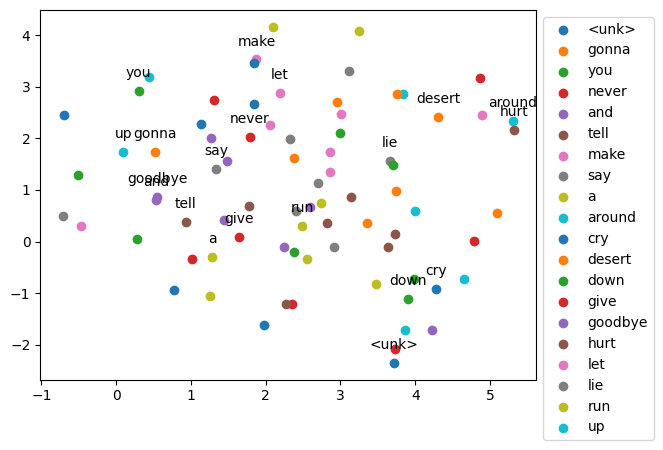

In [96]:
# 1. show word embeddings from the created model
# 2. reduce their dimensionality to 2D using t-SNE
# 3. plot embeddings as a scatter plot
# 4. annotate first 20 points with corresponding words
X = model_8.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

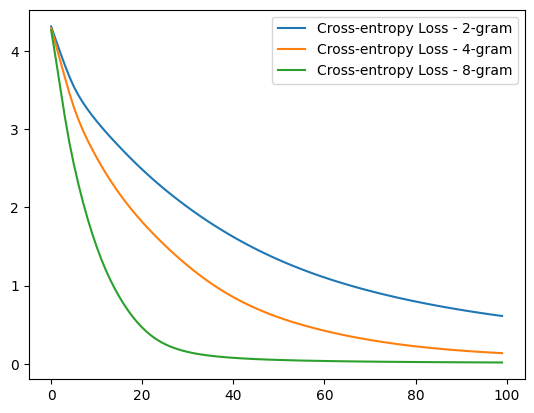

In [97]:
for (my_loss, model_name)in zip(my_loss_list,["2-gram","4-gram","8-gram"]):
    plt.plot(my_loss,label="Cross-entropy Loss - {}".format(model_name))
    plt.legend()

## Perplexity

Perplexity is a measurement used to evaluate the effectiveness of language models or probability models.  It is derived from the concept of cross-entropy loss, which measures the dissimilarity between predicted probabilities and actual probabilities.

$$\text{Cross-Entropy Loss} = -\sum_{i=1}^{N} y_i \ln(p_i)$$

$$\text{Perplexity} = e^{\frac{1}{N} \text{Cross-Entropy Loss}}$$

Lower perplexity indicates more accurate model predictions.

Perplexity can be seen as an estimate of the average number of choices the model has for the next word or event in a sequence.

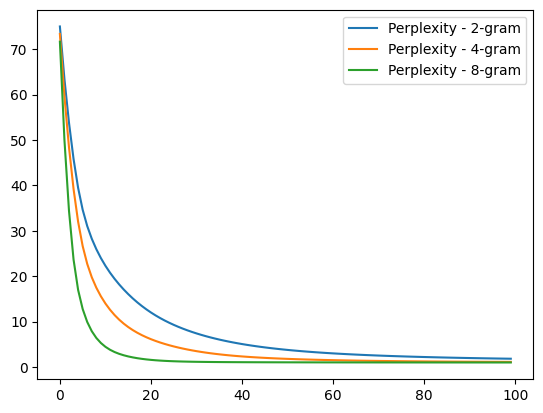

In [99]:
for (my_loss, model_name)in zip(my_loss_list,["2-gram","4-gram","8-gram"]):
    import numpy as np

    # Calculate perplexity using the loss
    perplexity = np.exp(my_loss)
    plt.plot(perplexity,label="Perplexity - {}".format(model_name))
    plt.legend()

# Exercises

In [100]:
# Source a collection of nursery rhymes and compile them into a single text variable
nursery_rhymes = """
Little Miss Muffet
Sat on a tuffet,
Eating her curds and whey;
Along came a spider
Who sat down beside her
And frightened Miss Muffet away.

Twinkle, twinkle, little star,
How I wonder what you are!
Up above the world so high,
Like a diamond in the sky.

Baa, baa, black sheep,
Have you any wool?
Yes sir, yes sir,
Three bags full.

Jack and Jill went up the hill
To fetch a pail of water.
Jack fell down and broke his crown,
And Jill came tumbling after.

Hickory dickory dock,
The mouse ran up the clock.
The clock struck one,
The mouse ran down,
Hickory dickory dock.

Humpty Dumpty sat on a wall,
Humpty Dumpty had a great fall.
All the king's horses and all the king's men
Couldn't put Humpty together again.

Mary had a little lamb,
Its fleece was white as snow;
And everywhere that Mary went,
The lamb was sure to go.

Old MacDonald had a farm,
E-I-E-I-O,
And on his farm he had a cow,
E-I-E-I-O.

Itsy Bitsy Spider climbed up the waterspout.
Down came the rain and washed the spider out.
Out came the sun and dried up all the rain,
And the Itsy Bitsy Spider climbed up the spout again.

The wheels on the bus go round and round,
Round and round,
Round and round.
The wheels on the bus go round and round,
All through the town.

"""

In [103]:
# Preprocess the text data to tokenize and create n-grams
N=2
tokens = preprocess(nursery_rhymes)
ngrams = list(nltk.ngrams(tokens, N))

In [119]:
tokenized_rhymes = map(tokenizer, nursery_rhymes.split())
vocab = build_vocab_from_iterator(tokenized_rhymes, specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
index_to_token = vocab.get_itos()

In [120]:
Padding=BATCH_SIZE-len(tokens)%BATCH_SIZE
tokens_pad=tokens+tokens[0:Padding]
dataloader = DataLoader(
     tokens_pad, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch
)

In [121]:
# Train an N-gram language model using the provided code structure
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
loss_history = train(dataloader, model)

 10%|█         | 10/100 [00:00<00:01, 47.21it/s]

Generated Song:


 wool came full bus sun after after diamond farm the bus . white sir s dumpty after after sun fell fell the sun washed diamond wall together what beside came tumbling s fell like after sun sir have came tumbling out wall along so little bus along cow sun in tumbling eating you what like s bus together fell wool had wool . tumbling s wool . clock you sun . diamond after everywhere so any s sun humpty tumbling after after diamond sir fell . wheels cow like waterspout hickory town sun town in came sun . bus after


 21%|██        | 21/100 [00:00<00:01, 47.67it/s]

Generated Song:


 the the the the the the the the the the round the the the the the the the the beside the the the the the the out the little the the the the the the the the the the world the the the the the the the the the the the the the the the the the the the sir the the the and down the the the the the the the the the round the s little down and the the the the the the little the the the the the the the the the the the the struck
Generated Song:


 little miss the sir round the little the her curds round round the baa down little little up down beside down the round round round the out the little star her down the rain the little a the the world baa the baa out the baa the the baa baa the the s the the s the the yes sir and again round and down the down baa the hill down the the a round little s and down and the the great the round little round the hickory dickory the the the he the the the down clock struck


 38%|███▊      | 38/100 [00:00<00:01, 50.68it/s]

Generated Song:


 little miss the sir round the little star her curds round round the baa down little little up down beside down and round round round the out the little star her down little rain the little a the the world baa curds spider out the had the the baa baa the the s the baa s little the yes sir and everywhere round everywhere down the down baa the hill baa little the a round king s and down and clock the great the hickory little round the hickory dickory the the the he the the the down clock struck
Generated Song:


 little miss the sir round the little star her curds round round the baa down bus little up down beside down and round round king the out the little star her down little rain the little a the the world baa curds spider out the had the the baa baa the round s the baa s little the yes sir and everywhere curds everywhere down the down baa the hill baa little the everywhere round king s and down and clock the great the yes little round the hickory dickory great the 

 60%|██████    | 60/100 [00:01<00:00, 49.02it/s]

Generated Song:


 little miss the sir round the little star her curds round round the baa down bus little up down beside down and round round king the out the little star her down out rain the little a the the world baa curds spider out the had the the baa baa the round s the baa s little the yes sir and everywhere curds everywhere down the down baa the hill baa little the everywhere round king s and down and clock the great the yes little round the hickory dickory great the the he the the the down clock struck


 65%|██████▌   | 65/100 [00:01<00:00, 48.32it/s]

Generated Song:


 little miss the sir round the little star her curds round round the baa down bus little up down beside down and round round king the out the little star her down out rain the little a the the world baa curds spider out the had the the baa baa the round s the baa s little the yes sir and everywhere curds everywhere down the down baa the hill baa little the everywhere round king s and down and clock dumpty great the yes little round the hickory dickory great the the he the the the down clock struck


 76%|███████▌  | 76/100 [00:01<00:00, 42.47it/s]

Generated Song:


 little miss the sir round the little star her curds round round the baa down bus little up down beside down and round round king the out the little star her down out rain the little a the the world her curds spider out the had the the baa baa the round s great baa s little the yes sir and everywhere curds everywhere down everywhere down baa the hill baa little the everywhere round king s and down and clock dumpty great the yes little round the hickory dickory great the the he the the the down clock struck


 86%|████████▌ | 86/100 [00:01<00:00, 39.35it/s]

Generated Song:


 little miss the sir round the little star her curds round round the baa down bus little up down beside down and round round king the out the little star her down out rain the little a the the world her curds spider out the had the the baa baa the round s great baa s little the yes sir and everywhere curds everywhere down everywhere down baa the hill baa little the everywhere round king s and down and clock dumpty great the yes little round the hickory dickory great the the he the the the down clock struck


 98%|█████████▊| 98/100 [00:02<00:00, 38.06it/s]

Generated Song:


 little miss the sir round the little star her curds round round the baa down bus little up down beside down and round round king the out the little star her down out rain the little a the the world her curds spider out the had the the baa baa the round s great baa s little the yes sir and everywhere curds everywhere down everywhere down baa the hill baa little the everywhere round king s and down and clock dumpty great the yes little round the hickory dickory great the the he the the the down clock struck


100%|██████████| 100/100 [00:02<00:00, 43.76it/s]


In [122]:
generated_rhyme = write_song(model)
print(generated_rhyme)

 little miss the sir round the little star her curds round round the baa down bus little up down beside down and round round king the out the little star her down out rain the little a the the world her curds spider out the had the the baa baa the round s great baa s little the yes sir and everywhere curds everywhere down everywhere down baa the hill baa little the everywhere round king s and down and clock dumpty great the yes little round the hickory dickory great the the he the the the down clock struck
